In [1]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
jet = plt.get_cmap('jet')
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy import stats, array
import math
from tqdm import tqdm
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,median_absolute_error, silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
import loo_q2 as loo
randomstate = 42
import rdkit
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, PropertyMol, Draw, rdmolfiles, rdFMCS
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
import kennardstonealgorithm 
from PIL import Image

# Load data

In [2]:
ci = pd.read_excel('example_descriptors.xlsx','descriptors',index_col=0,header=1,engine='openpyxl')
compinp = ci[ci.columns[1:-3]].loc[ci.index[:]]
compinp.index = compinp.index.astype(int)
compinp.dropna(axis=0,inplace=True)

inp2 = pd.read_excel("example_identifiers.xlsx",index_col=1,header=2,engine='openpyxl')
inp2.index = inp2.index.astype(int)

print(len(inp2.index),'ligands in identifiers file')
print(len(compinp.index),'ligands in descriptors file')

1776 ligands in identifiers file
1544 ligands in descriptors file


**Remove colinear descriptors and remove descriptors with all values = 0 (optional)**

If a pair of descriptors have an Pearson correlation coefficient (r) value greater than the threshold one descriptor will be removed.

In [3]:
threshold = 0.95

print('Shape of descriptors file before curation: ',compinp.shape)
#compinp = compinp.astype(float)
df_corr = compinp.corr()
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
compinp = compinp[un_corr_idx]

compinp = compinp.loc[:, (compinp != 0).any(axis=0)]

print('Shape of descriptors file after curation: ',compinp.shape)

Shape of descriptors file before curation:  (1544, 190)
Shape of descriptors file after curation:  (1544, 139)


**Define subsets, scale descriptors, and run PCA**

Several ligands in the identifiers file are not found in the descriptors file (e.g. 1419). Code below removes any ligands that do not have descriptors.

In [4]:
X_all = np.array(compinp)
X_com = np.array(compinp.loc[inp2["COM"]==1])
X_sigma = np.array(compinp.loc[inp2["sigma"]==1])

X_all_ids = np.array(compinp.index)
X_com_ids = np.array(compinp.loc[inp2["COM"]==1].index)
X_sigma_ids = np.array(compinp.loc[inp2["sigma"]==1].index)

X_all_names = np.array(inp2["ligand"].loc[X_all_ids])
X_com_names = np.array(inp2['ligand'].loc[X_com_ids])
X_sigma_names = np.array(inp2['ligand'].loc[X_sigma_ids])

scaler = StandardScaler()
scaler.fit(X_all)

X_all_sc    = scaler.transform(X_all)
X_com_sc    = scaler.transform(X_com)
X_sigma_sc = scaler.transform(X_sigma)

pca = PCA(n_components=4)
pca.fit(X_all_sc)

X_all_pca    = pca.transform(X_all_sc)
X_com_pca    = pca.transform(X_com_sc)
X_sigma_pca   = pca.transform(X_sigma_sc)

pca_score = pca.explained_variance_ratio_
pca_values = pca.singular_values_
V = pca.components_

print('Total variance explained by PCs:',round(np.sum(pca.explained_variance_ratio_*100),1),'%\n')
print("Percentage of explained variance per principal component")
for i,j in enumerate(pca_score):
    print(f"PC{i+1}   {j*100:.1f}%")

Total variance explained by PCs: 57.1 %

Percentage of explained variance per principal component
PC1   26.8%
PC2   13.2%
PC3   11.0%
PC4   6.2%


**2D score plot**

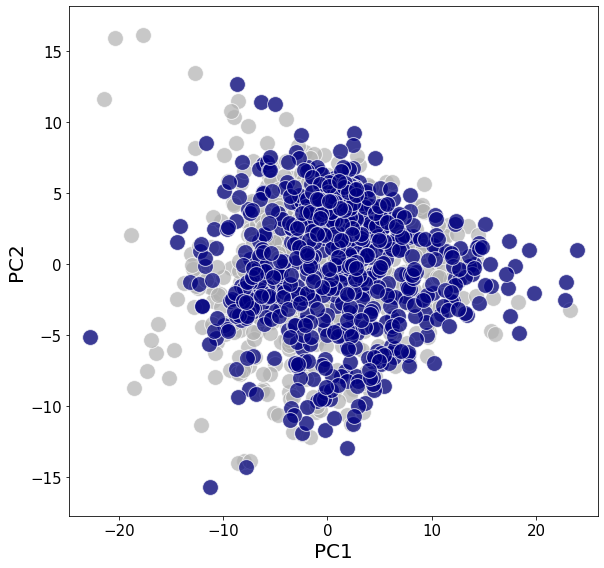

In [5]:
X_use = X_all_pca
X_ids = X_all_ids

X_subset = X_com_pca
X_subset_ids = X_com_ids

x_min, x_max = X_use[:,0].min() - 2, X_use[:,0].max() + 2
y_min, y_max = X_use[:,1].min() - 2, X_use[:,1].max() + 2
plt.figure(figsize=(8.5,8))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15),plt.yticks(fontsize=15)
plt.xlabel(f"PC1",fontsize=20),plt.ylabel(f"PC2",fontsize=20)
plt.locator_params(axis='y', nbins=10),plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max),plt.ylim(y_min,y_max) 
plt.scatter(X_use[:,0], X_use[:,1],c='#B1B1B1',alpha=0.7,marker=".",s=1000,edgecolor='white') 
plt.scatter(X_subset[:,0], X_subset[:,1],c="#000080",alpha=0.7,marker=".",s=1000,edgecolor='white')

plt.tight_layout()
#plt.show()
#plt.savefig("2D_pca.png",dpi=300)

# Identify the optimal number of clusters

The optimal number of clusters depends on the method used for measuring similarities and the parameters used for partitioning. Hence, while the elbow method shown below is one of the most common but is not conclusive. It works by plotting the within cluster sum of squares (WCSS) vs no. of clusters (k). WCSS should be minimized. A sharp "elbow" where adding clusters doesn't lower WCSS indicates the optimal k has been reached

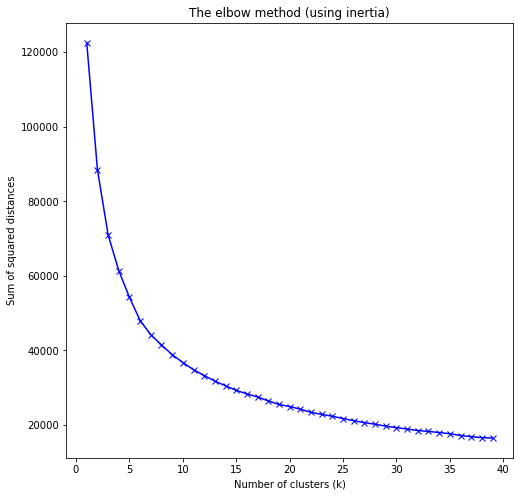

In [6]:
X_use = X_all_pca    # set to be analyzed

Sum_of_squared_distances = []
K = range(1,40) # K is the number of clusters to be checked
#K = [1,3,5,7,9,11,13,15,17,19,21,23,25]
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(X_use)
    Sum_of_squared_distances.append(km.inertia_)

#print("For n_clusters =", K,"\nThe Sum_of_squared_distances :", Sum_of_squared_distances)

plt.close()
plt.figure(figsize=(8,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)'),plt.ylabel('Sum of squared distances')
plt.title('The elbow method (using inertia)')
#plt.savefig("elbow.png",dpi=300)
plt.show()

# K-means clustering

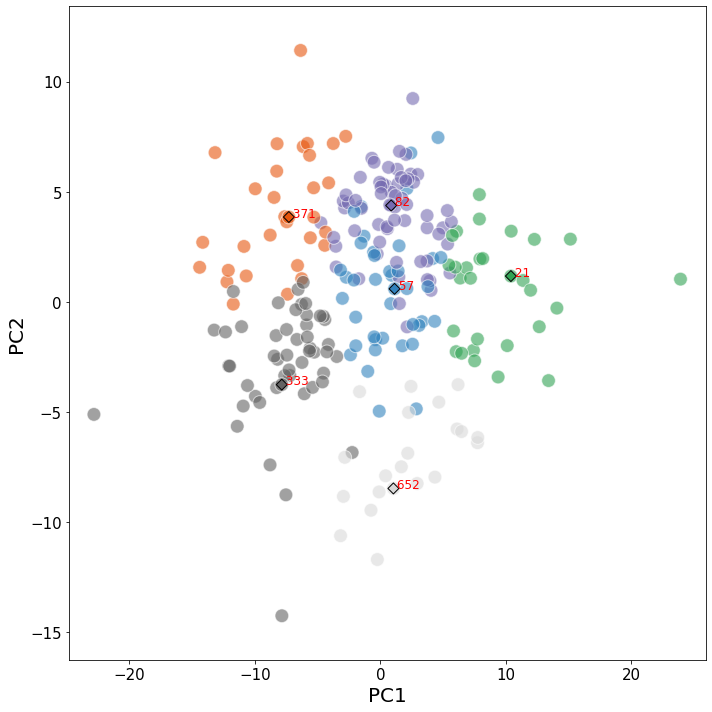

In [7]:
X_use = X_sigma_pca
X_use_ids = X_sigma_ids

nclusters = 6

####################################################################################

X_kmeans = X_use                 #array containing the PC values for each individual ligand
kmeans = KMeans(n_clusters=nclusters, random_state=42).fit(X_kmeans)

dists = []                       #distances for each ligand from cluster centre
for x in range(len(X_kmeans)):
    delta = [X_kmeans[x,i]-kmeans.cluster_centers_[kmeans.labels_[x],i] for i in range(len(X_kmeans[0]))]
    dist = np.linalg.norm(delta)
    dists.append(dist)

clusters = {}                     #key = cluster number, value = indices (row numbers) of the ligands in that cluster (0 indexed)
clusterdists = {}                 #key = cluster number, value = distance of ligand to the centroid
clustermins = []                  #indices of the ligands closest to the cluster centre
clusterorders_dict = {}           #key = cluster, values = indices for ligands ordered by distance from centroid
clusterorders = np.zeros(X_kmeans.shape[0]) #ligand IDs in order of each ligand’s distance to the cluster centre

for x in range(nclusters):
    clusters[x] = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == x]
    clusterdists[x] = [dists[i] for i in clusters[x]]
    clustermins.append(clusters[x][clusterdists[x].index(min(clusterdists[x]))])
    clusterorders_dict[x] = [y for _,y in sorted(zip(clusterdists[x],clusters[x]))]
    for i in clusters[x]:
        clusterorders[i] = clusterorders_dict[x].index(i)+1

row_id = list(enumerate(X_use_ids)) # the row and corresponding ids
clusters_with_ids = {}
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append(row_id[clusters[i][j]][1])
    clusters_with_ids[i] = emptylist

centroids_with_ids = []
for j in clustermins:
    for i in range(0,len(row_id)):
        if row_id[i][0] == j:
            centroids_with_ids.append(row_id[i][1])

f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = X_kmeans[:, f_ind_1].min() - 2, X_kmeans[:, f_ind_1].max() + 2
y_min, y_max = X_kmeans[:, f_ind_2].min() - 2, X_kmeans[:, f_ind_2].max() + 2
plt.figure(figsize=(10,10))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15),plt.yticks(fontsize=15)
plt.xlabel(f"PC1",fontsize=20),plt.ylabel(f"PC2",fontsize=20)
plt.locator_params(axis='y', nbins=10),plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max),plt.ylim(y_min,y_max)
mapping = kmeans.labels_
cMap = "tab20c"
plt.scatter(X_kmeans[:,f_ind_1], X_kmeans[:,f_ind_2],c=mapping,cmap=cMap,alpha=0.6,marker=".",s=750,edgecolor='white')

### plot all ids
#for i in range(0,nclusters):
#    for j in range(0,len(clusters_with_ids[i])):
#        plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="blue",fontsize=12,ha="left")

### plot centroids
plt.scatter(X_use[clustermins,f_ind_1],X_use[clustermins,f_ind_2],c=range(nclusters),cmap=cMap,alpha=1,marker="D",s=60,edgecolor="black",linewidth=1)

### plot centroid ids (works but could be updated to use 'centroids_with_ids' instead)
for i in range(0,nclusters):
    for j in range(0,len(clusters_with_ids[i])):
        if clusters[i][j] in clustermins:
            plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="red",fontsize=12,ha="left")

plt.tight_layout()
#plt.savefig("pca_clusters.png",dpi=300)
#plt.show()

**3D score plot**

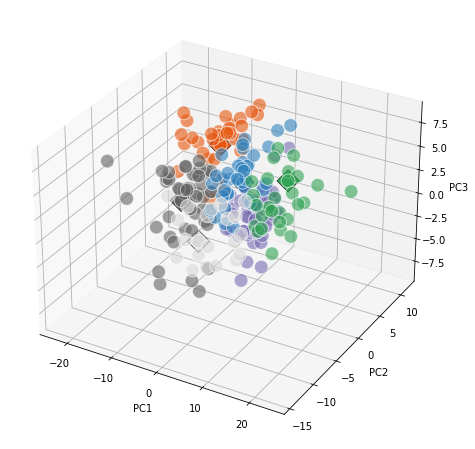

In [8]:
#%matplotlib notebook

np.random.seed(19680801)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
mapping = kmeans.labels_
cMap = "tab20c"
ax.scatter(X_kmeans[:,0],X_kmeans[:,1],X_kmeans[:,2],c=mapping,cmap=cMap,alpha=0.6,marker=".",s=750,edgecolor='white')
ax.scatter(X_kmeans[clustermins,0],X_kmeans[clustermins,1],X_kmeans[clustermins,2],c=range(nclusters), marker="D",s=250,alpha=1,cmap=cMap,edgecolor="black",linewidth=0.5)
ax.set_xlabel('PC1'),ax.set_ylabel('PC2'),ax.set_zlabel('PC3')
#plt.savefig("3D_pca_clusters.png",dpi=300)
plt.show()

**Rotating 3D score plot**

In [ ]:
%matplotlib notebook

np.random.seed(19680801)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
mapping = kmeans.labels_
cMap = "tab20c" #discrete color scheme
ax.scatter(X_kmeans[:,0],X_kmeans[:,1],X_kmeans[:,2], marker=".",s=20,alpha=0.5,c=mapping,cmap=cMap,)
ax.scatter(X_kmeans[clustermins,0],X_kmeans[clustermins,1],X_kmeans[clustermins,2],c=range(nclusters), marker="D",s=20,alpha=1,cmap=cMap,edgecolor="black",linewidth=0.5)
ax.set_xlabel('PC1'),ax.set_ylabel('PC2'),ax.set_zlabel('PC3')
plt.show()
def rotate(angle):
    ax.view_init(azim=angle)
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=150)
#rot_animation.save('pca_3d_rotation.gif', dpi=80, writer='imagemagick')

**Distances for each compound to cluster centroid**

In [9]:
row_dists = list(enumerate(dists)) # add row numbers to the distances
clusters_id_dist = {}
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append((clusters_with_ids[i][j],np.around(row_dists[clusters[i][j]][1],decimals=2))) # for row numbers add clusters[i][j]
    clusters_id_dist[i] = emptylist
print('Clusters with ligand id and distance to centroid:',clusters_id_dist,'\n')

Clusters with ligand id and distance to centroid: {0: [(8, 8.65), (9, 4.38), (10, 3.39), (11, 2.29), (12, 7.2), (20, 7.03), (30, 5.11), (32, 3.09), (57, 1.49), (64, 3.12), (65, 3.63), (66, 4.28), (67, 1.77), (68, 2.21), (70, 4.09), (77, 4.31), (162, 3.22), (212, 4.3), (238, 4.86), (241, 4.98), (293, 4.24), (301, 2.84), (308, 3.43), (343, 4.83), (449, 2.78), (456, 6.76), (471, 2.85), (472, 4.63), (485, 4.0), (488, 5.03), (532, 5.02), (611, 5.99), (643, 4.84), (645, 3.99), (647, 5.68), (648, 5.52), (654, 4.77), (655, 4.51), (657, 6.03), (1408, 5.59)], 1: [(37, 4.28), (42, 4.77), (50, 6.31), (60, 7.57), (89, 3.36), (90, 3.63), (91, 4.14), (103, 4.21), (276, 4.04), (280, 4.42), (281, 4.82), (291, 6.48), (292, 5.02), (296, 4.4), (299, 6.82), (306, 2.24), (310, 6.21), (315, 3.11), (322, 4.55), (323, 4.67), (330, 7.69), (338, 2.2), (340, 8.02), (344, 4.77), (347, 6.46), (348, 5.72), (349, 6.32), (365, 4.91), (371, 1.58), (527, 3.38), (534, 5.61)], 2: [(14, 5.39), (21, 2.46), (22, 6.45), (72, 

**Print the molecular structures closest to the centroids**

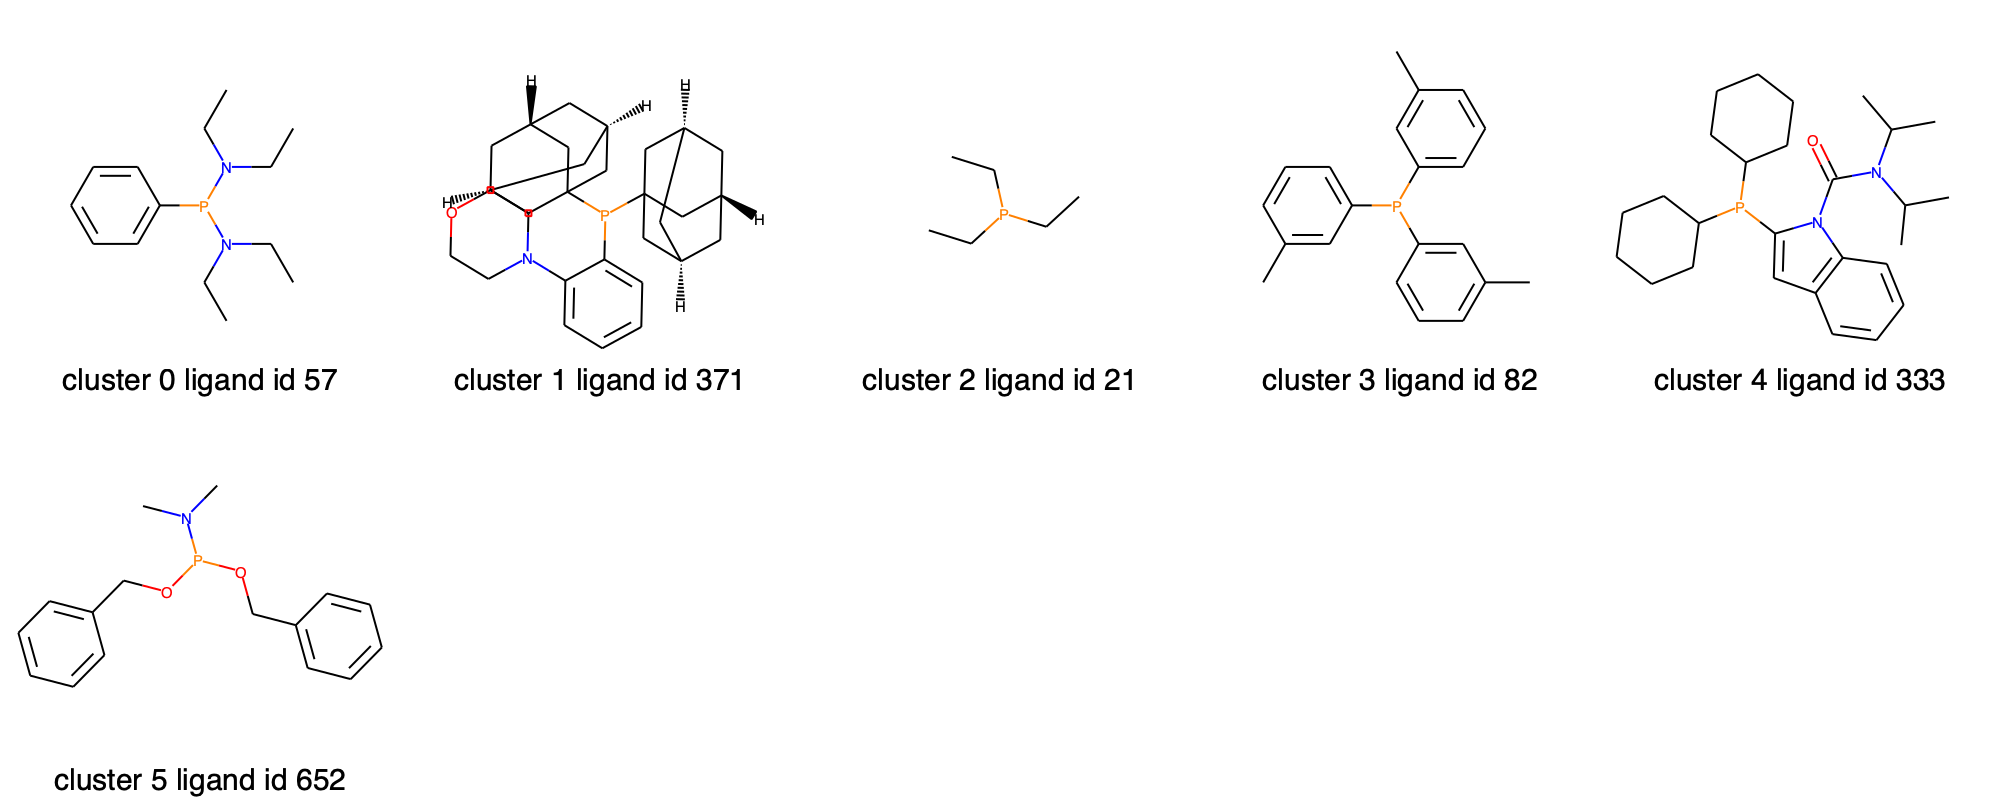

In [10]:
centroid_smiles = np.array(inp2['SMILES'].loc[centroids_with_ids]) 
substructure = Chem.MolFromSmiles('CP(C)C')

count=0
subms = []
for i in centroid_smiles:
    x = Chem.MolFromSmiles(i)
    #tmp=AllChem.Compute2DCoords(x)                                  # gave issues with some ligands
    #AllChem.GenerateDepictionMatching2DStructure(x,substructure)    # used to align molecules
    count+=1
    subms.append(x)

clusters_and_centroidswithids = list(enumerate(centroids_with_ids))   
my_labels = []
for i in range(0,len(clusters_and_centroidswithids)):
    x = 'cluster '+str(clusters_and_centroidswithids[i][0])+'ligand id '+str(clusters_and_centroidswithids[i][1])
    my_labels.append('cluster '+str(clusters_and_centroidswithids[i][0])+' ligand id '+str(clusters_and_centroidswithids[i][1]))
    
molsPerRow = 5                    # molecules per row
subImgSize= (400,400)             # image quality for the smiles
nRows = -(count // -molsPerRow)   # // = floor division: gives lowest interger after performing the division
fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1]) # defining width and height
img = rdMolDraw2D.MolDraw2DCairo(fullSize[0],fullSize[1],subImgSize[0], subImgSize[1]) # setting up the image
img.drawOptions().legendFontSize=30                        # font size
img.DrawMolecules(subms[:],legends=my_labels[:])           # adding images and corresponding labels (must be str)
img.SetFontSize(100)                                       # not used at the moment
img.FinishDrawing()                                        # finish the image

# %s acts a placeholder for a string while %d acts as a placeholder for a number.
# their associated values are passed in via a tuple using the % operator
# wb+ = opens a file for both writing and reading in binary format. Overwrites the existing file if the file exists.
# if the file does not exist, creates a new file for reading and writing.

with open('name.png','wb+') as wfp:             # saves a png file into current folder
    wfp.write(img.GetDrawingText())             # saving in the image
Image.open('name.png')                          # opening it in the notebook

**Print all ligands in one cluster**

Early code relied on dataframe row numbers, was updated to use ligand IDs instead.

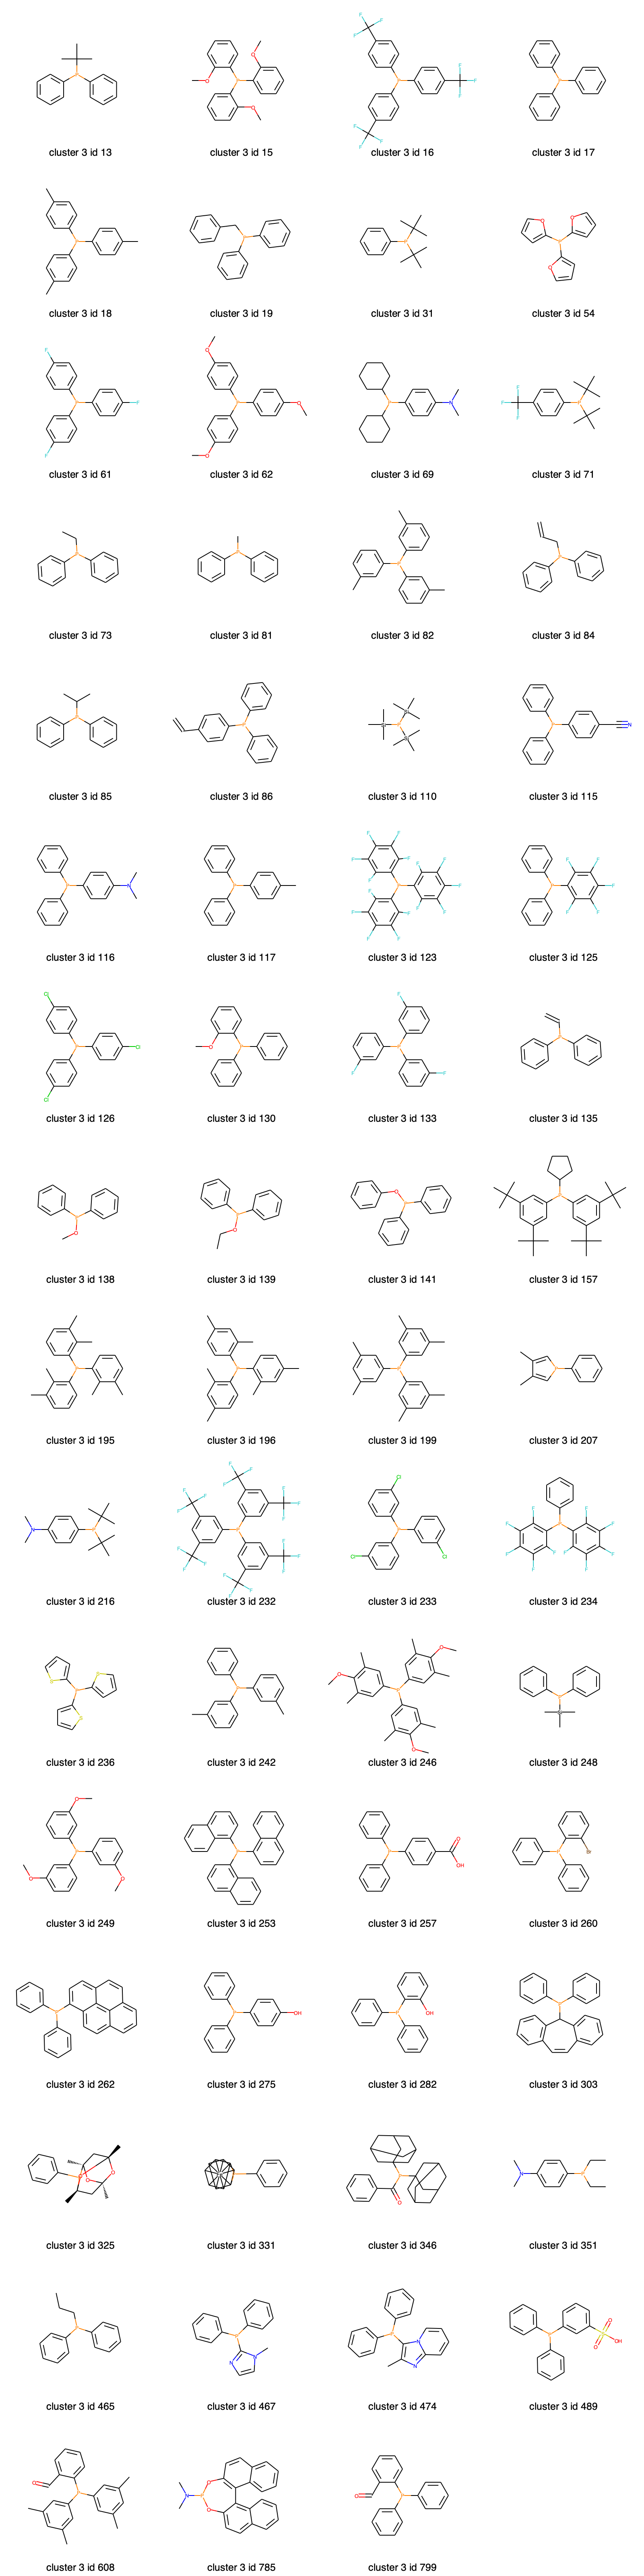

In [11]:
cluster = 3

###########################################################################

X_use_smiles = np.array(inp2['SMILES'].loc[X_use_ids])  # smiles for the compounds
X_use_row_smiles = list(enumerate(X_use_smiles))        # add row numbers to the SMILES (not IDs)

clusters_with_smiles = {}         # contains just the SMILES - used for visualization in next stage
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append(X_use_row_smiles[clusters[i][j]][1])
    clusters_with_smiles[i] = emptylist
clusters_to_use = clusters_with_smiles
clusters_to_use = dict( [(k,v) for k,v in clusters_to_use.items() if len(v)>0]) # removes empty keys

#substructure = Chem.MolFromSmiles('CP(C)C') # can be used to align molecules
count=0
subms = []
for j in clusters_to_use[cluster]:
    x = Chem.MolFromSmiles(j)
    #tmp=AllChem.Compute2DCoords(x) # gave issues with some ligands
    #AllChem.GenerateDepictionMatching2DStructure(x,substructure)   
    count+=1
    subms.append(x)

my_labels = []  
for j in range(0,len(clusters_with_ids[cluster])):   # clusters_with_ids comes from previous section
    x = 'cluster '+str(cluster)+' id %d'%(clusters_with_ids[cluster][j])
    my_labels.append(x)
    
molsPerRow = 4
subImgSize= (400,400)
nRows = -(count // -molsPerRow)
fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
img = rdMolDraw2D.MolDraw2DCairo(fullSize[0],fullSize[1],subImgSize[0], subImgSize[1])
img.drawOptions().legendFontSize=25
img.DrawMolecules(subms[:],legends=my_labels[:])
img.SetFontSize(100)
img.FinishDrawing()
with open('name.png','wb+') as wfp:
    wfp.write(img.GetDrawingText())
Image.open('name.png')

**Printing all ligands in all clusters**

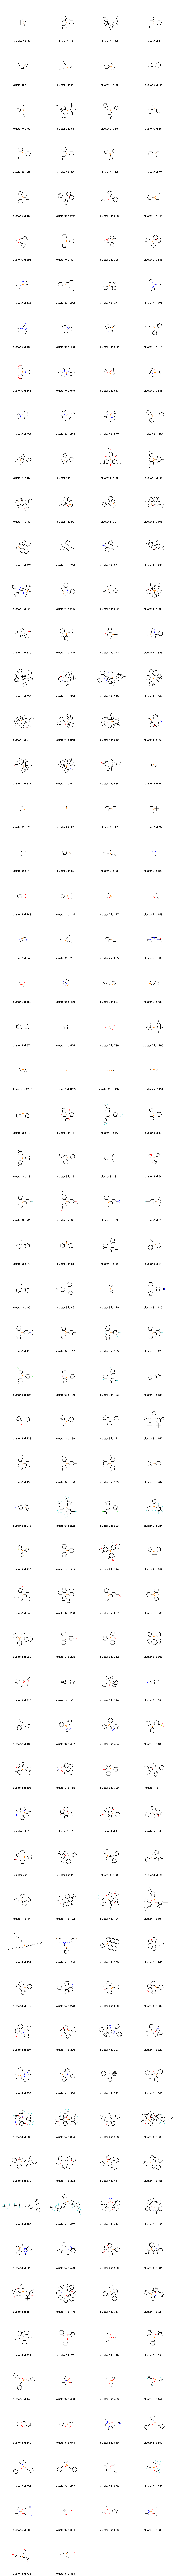

In [12]:
X_use_smiles = np.array(inp2['SMILES'].loc[X_use_ids])
X_use_row_smiles = list(enumerate(X_use_smiles))
clusters_with_smiles = {}
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append(X_use_row_smiles[clusters[i][j]][1])
    clusters_with_smiles[i] = emptylist
clusters_to_use = clusters_with_smiles
clusters_to_use = dict( [(k,v) for k,v in clusters_to_use.items() if len(v)>0]) # removes empty keys

#substructure = Chem.MolFromSmiles('CP(C)C') # can be used to align molecules
count=0
subms = []
for i in clusters_to_use:
    for j in clusters_to_use[i]:
        x = Chem.MolFromSmiles(j)
        #tmp=AllChem.Compute2DCoords(x)
        #AllChem.GenerateDepictionMatching2DStructure(x,substructure)
        count+=1
        subms.append(x)

my_labels = []  
for i in range(0,len(clusters_with_ids)):
    for j in range(0,len(clusters_with_ids[i])):
        my_labels.append('cluster %d id %d'%(i,clusters_with_ids[i][j]))

molsPerRow = 4
subImgSize= (400,400)
nRows = -(count // -molsPerRow)
fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
img = rdMolDraw2D.MolDraw2DCairo(fullSize[0],fullSize[1],subImgSize[0], subImgSize[1])
img.drawOptions().legendFontSize=25
img.DrawMolecules(subms[:],legends=my_labels[:])
img.SetFontSize(100)
img.FinishDrawing()
with open('name.png','wb+') as wfp:
    wfp.write(img.GetDrawingText())
Image.open('name.png')

# Kennard-Stone algorithm (8-18-20)

KS works with the scaled descriptors (doesn't use PC values). The descriptor subset and number of desired samples are specified in line 1.

https://github.com/hkaneko1985/kennardstonealgorithm

In [13]:
X_use = X_com_sc
X_use_ids = X_com_ids
number_of_samples = 12

####################################

selected_sample_numbers, remaining_sample_numbers = kennardstonealgorithm.kennardstonealgorithm(X_use, number_of_samples)

X_use_row_id = list(enumerate(X_use_ids)) 

selected_sample_ids = []
for i in selected_sample_numbers:
    for j in range(0,len(X_use_row_id)):
        if X_use_row_id[j][0] == i:
            selected_sample_ids.append(X_use_row_id[j][1])

remaining_sample_ids = []
for i in remaining_sample_numbers:
    for j in range(0,len(X_use_row_id)):
        if X_use_row_id[j][0] == i:
            remaining_sample_ids.append(X_use_row_id[j][1])

print("selected sample ids")
print(selected_sample_ids)
#print("---\nremaining sample ids")
#print(remaining_sample_ids)

selected sample ids
[369, 1299, 153, 1430, 310, 543, 396, 486, 871, 582, 1487, 137]


**Descriptor plot**

Plot 1-2 descriptors and check the diversity of the KS samples. Check a variety of descriptors against themselves to validate that it's picked a diverse set e.g. descriptor1 = 0 and descriptor2 = 0.

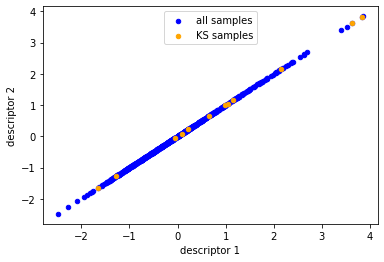

In [14]:
descriptor1 = 0
descriptor2 = 0

plt.figure()
plt.scatter(X_use[:,descriptor1], X_use[:,descriptor2], marker='.',s=80,c='blue',label="all samples")
plt.scatter(X_use[selected_sample_numbers,descriptor1], X_use[selected_sample_numbers,descriptor2],marker=".",s=80,c='orange',label="KS samples")
plt.xlabel("descriptor 1")
plt.ylabel("descriptor 2")
plt.legend(loc='upper center')
plt.show()

# Neighbour analysis (8-17-20)

indices = array with the row number for each ligand and its nearest neighbors (doesn't use ligand IDs)

distances = array with the distances for each ligand to itself (0) and its nearest neighbors

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors

http://zetcode.com/python/fstring/ {x:y.zf} y = column width, z = number of decimal points

In [15]:
query = "10"          # ligand ID (label in the descriptor file)
n_neighbors = 10      # how many neighbors required
use_space = "PCA"     # "PCA" or "descriptors" = the feature space to look for neighbors

if use_space == "PCA":
    X_neighbors = X_all_pca       # change to subset if desired
elif use_space == "descriptors":
    X_neighbors = X_all_sc

nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute').fit(X_neighbors)
distances, indices = nbrs.kneighbors(X_neighbors)

y_labels = np.asarray(list(compinp.index),dtype=str) # the ligand ids from the descriptor file
q_nbrs = indices[np.where(y_labels == query)][0] # find row number for query ligand ID, use it to get appropriate index
q_nbrs_label = [y_labels[i] for i in q_nbrs] # the IDs for the ligands in the index (instead of row numbers)

print("       dist     ligand ID")
for i in range(1,len(q_nbrs)):  # skips the first because that would be the distance of the ligand to itself
    print(f"{i:3}  {distances[np.where(y_labels == query)][0][i]:7.3f}    {q_nbrs_label[i]}")

       dist     ligand ID
  1    0.771    64
  2    1.350    1140
  3    1.623    285
  4    1.852    179
  5    1.990    1109
  6    2.029    1141
  7    2.118    1660
  8    2.176    1091
  9    2.204    107


# Coverage of chemical space by a subset

Method to quantify coverage of one set of molecules by another set. The main set is clustered, then the clusters containing a molecule from the subset are counted.

In [16]:
X_use = X_all_pca
X_main_ids = X_all_ids
X_subset_ids = X_com_ids
nclusters = 100

####################################################################################

X_kmeans = X_use
kmeans = KMeans(n_clusters=nclusters, random_state=42).fit(X_kmeans)
dists = []
for x in range(len(X_kmeans)):
    delta = [X_kmeans[x,i]-kmeans.cluster_centers_[kmeans.labels_[x],i] for i in range(len(X_kmeans[0]))]
    dist = np.linalg.norm(delta)
    dists.append(dist)
clusters = {} # clusters with main set row numbers
clusterdists = {}
clustermins = []
clusterorders_dict = {}
clusterorders = np.zeros(X_kmeans.shape[0])
for x in range(nclusters):
    clusters[x] = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == x]
    clusterdists[x] = [dists[i] for i in clusters[x]]
    clustermins.append(clusters[x][clusterdists[x].index(min(clusterdists[x]))])
    clusterorders_dict[x] = [y for _,y in sorted(zip(clusterdists[x],clusters[x]))]
    for i in clusters[x]:
        clusterorders[i] = clusterorders_dict[x].index(i)+1

main_row_id = list(enumerate(X_main_ids)) # main set row and ligand ID

clusters_with_ids = {} # clusters with ligand ids
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        #print('row and id = ',main_row_id[clusters[i][j]])
        emptylist.append(main_row_id[clusters[i][j]][1])
    clusters_with_ids[i] = emptylist

subset_row_id = []   # the main set row number and ligand id for the subset selection
for i in range(0,len(main_row_id)):
    for j in range(0,len(X_subset_ids)):    # X_subset_ids = ligand IDs for subset selection (1 indexed)
        if main_row_id[i][1] == X_subset_ids[j]:
            subset_row_id.append((main_row_id[i][0],X_subset_ids[j]))
            
subset_row = []    # make a list of only the row numbers for subset selection
for i in range(0,len(subset_row_id)):
    subset_row.append(subset_row_id[i][0])

clusters_with_ligands = []     # clusters for ligands in subset
cluster_row = []               # cluster and row numbers for subset
for i in range(0,nclusters):   # search through the clusters for the subset row numbers (subset_row)
    for j in range(0,len(subset_row)):
        if subset_row[j] in clusters[i]:
            clusters_with_ligands.append(i)
            cluster_row.append((i,subset_row[j]))  
clusters_with_ligands = list(dict.fromkeys(clusters_with_ligands))     #removes duplicates from list

cluster_id = [] # cluster and ligand id for subset
for i in range(0,len(cluster_row)): # translate to ligand ids
    for j in range(0,len(subset_row_id)):
        if cluster_row[i][1] == subset_row_id[j][0]:
            cluster_id.append((cluster_row[i][0],subset_row_id[j][1]))

print('number of ligands in main set:',len(X_use),'\n')
print('number of clusters for main set:',nclusters,'\n')
print('average ligands per cluster:',len(X_use)/nclusters,'\n')
print('number of ligands in subset:',len(X_subset_ids),'\n')
print('number of subset ligands in the main set (ligands that are not present are excluded from the analysis):',len(subset_row_id),'\n')
print('clusters containing ligands from subset:',clusters_with_ligands,'\n')
print(len(clusters_with_ligands),'out of',nclusters,'clusters contain a ligand from the subset','\n')

number of ligands in main set: 1544 

number of clusters for main set: 100 

average ligands per cluster: 15.44 

number of ligands in subset: 689 

number of subset ligands in the main set (ligands that are not present are excluded from the analysis): 689 

clusters containing ligands from subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 

92 out of 100 clusters contain a ligand from the subset 

